In [18]:
! conda update scikit-learn -y > /dev/null
! pip install -e lib/ > /dev/null

# Kaggle - G-Research Crypto Forecasting | Model Fitting

In this notebook we use the features constructed in the previous notebook and fit models testing various ideas.

### Personal Time Constraints
Due to time constraints, a lot of ideas from the `init.ipynb` notebook do not make it here and the testing I do here should be more detailed. I will however be satisfied with the outcome if I've been able to clearly present some interesting ideas - even if the result could be improved.


## Training approaches
Below I outline some of the ideas I intend to test in this notebook:

### Time Reversal
Viewing price evolution as a physical process we would expect it to have time symmetry (the same process can happen backwards in time).

This almost doubles the amount of data we have, so we should be able to fit better models (assuming the time resersal construction is valid).

Update: this idea wasn't tested since I anticipated it will be difficult to implement due to the competition's computational (RAM) constraints.

### Model Types
Tree models are desirable due to their robustness to feature normalisation and for (relatively) low computational demands (at least in the LGBM implementation). We will test these and lasso models since these are simple and can serve as a benchmark.

I expect explicit sequence models (eg LSTM) will also be useful, however I expect we'll run into memory issues if not careful with data processing, so we don't explore these.


### Training Setup
As discussed in the previous notebook we will explore the following model setups:
- Single asset

... and for each cluster:
- Pool
- Panel

... and for all assets:
- Pool

We expect that (and check) these different training approaches will work better in combination than single asset models.


#### Clusters
From the data exploration notebook, we found 5 clusters. We'd like panel + pool models for each cluster so move 7 into (0, 3, 12) since these are pairwise correlated:
- Dogecoin, IOTA, Maker, Monero (4, 8, 10, 11)
- Binance Coin, Cardano, Ethereum Classic, Stellar (0, 3, 7, 12)
- Bitcoin Cash, EOS.IO, TRON (2, 5, 13)
- Bitcoin, Ethereum, Litecoin (1, 6, 9)

## Prepare Data

In [3]:
import pickle
from functools import partial

import lightgbm
import numpy as np
import pandas as pd
import cvxpy as cp

from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler


from lib.data_utils import *
from lib.features import *
from lib.metrics import *
from lib.models import *
from lib.transformations import *
from lib.utils import *
from lib.cross_validation import *

ad = pd.read_csv("asset_details.csv").set_index("Asset_ID")
weights = ad["Weight"]
weights /= weights.sum()

clusters = {
    0: (4, 8, 10, 11),
    2: (0, 3, 12, 7), # move 7 in this cluster
    3: (2, 5, 13),
    4: (1, 6, 9),
} # arbitrary cluster labels


%load_ext autoreload
%autoreload 2

In [4]:
# all_features = all_feats(pd.read_csv("work/train.csv"), weights)

# with open("processed_data/all_features.pkl", "wb") as f:
#     pickle.dump(all_features, f)

with open("processed_data/all_features.pkl", "rb") as f:
    data = pickle.load(f)

### Train/Validation/Test split
Split into (roughly) 80/20 train/test splits and split the test set into a further validation set in the same ratio.

In [5]:
(train_ind, test_ind), = ts_split(data.index, 1, 0.2)
(train_ind, validation_ind), = ts_split(train_ind, 1, 0.2)

train = data.loc[train_ind]
train_stacked = train.stack()

target_weights = ad[["Weight"]].rename(columns={"Weight": "target_weight"})
train_stacked = train_stacked.join(target_weights, on="Asset_ID") # FIXME: this should be done in the library

cols = train.columns.get_level_values(0).unique()
features = [k for k in cols if "target" not in k]

## Baselines

### Single Asset Model
Look at models for Bitcoin (Asset_ID=1) for simplicity.

Note: no need to standardscale since we normalise for rolling mean + std deviation at each timestep - can check this across assets

In [9]:
train_1 = train.loc[:, (slice(None), 1)].iloc[300:].dropna()
timestamps_1 = train_1.index

(base_train, base_test), = ts_split(timestamps_1, 1, 0.2)

In [42]:
base_model = Pipeline([("scale", StandardScaler()), ("regress", Lasso(alpha=1e-6))])

corr_func = lambda x, y: np.corrcoef(x, y)[0, 1]
eval_func = partial(evaluate_panel, metrics_func=corr_func, asset_labels=[1])

corr = fit_model(base_model, base_train, base_test, train_1, eval_func)[1][1]
print(corr)

0.005085550830016444


... 0.5% correlation: we expect to do better than this with more complex models - I suspect underfitting since the model is simple (considering the data set size + # of features).

In [43]:
insample_corr = fit_model(base_model, base_train, base_train, train_1, eval_func)[1][1]
print(insample_corr)

0.013259342918220157


## Information Decay
Let's quickly check for any obvious information leakage: intentionally leak/delay information to check the effect on the correlation.

The correlation increases drastically as soon as we leak forward information and decreases as we lag information - this is what we'd expect if there is no information leakage (and if we're using the latest information).

In [56]:
shifts = [-5, -1, 0, 1, 5]

shift_corrs = {}

for shift in shifts:
    train_1_copy = train_1.copy()
    train_1_copy.loc[:, features] = train_1_copy.loc[:, features].shift(shift, fill_value=0)
    corr = fit_model(base_model, base_train, base_train, train_1_copy, eval_func)[1][1]
    shift_corrs[shift] = corr
    
shift_corrs

{-5: 0.18992970400450615,
 -1: 0.09205940205206822,
 0: 0.013259342918220157,
 1: 0.01179552738747167,
 5: 0.006840268610342508}

### Increase Complexity

#### Trees
Let's try the same setup but using a tree-based model for more complexity. (Change the default learning rate (0.1) since since I suspect it is too high.)

We get a 1.5% correlation out of sample - better than the Lasso model's in sample correlation. This is consistent with the hypothesis that Lasso is underfitting.

In [57]:
tree_model = lightgbm.LGBMRegressor(learning_rate=0.04)
eval_func = partial(evaluate_panel, metrics_func=corr_func, asset_labels=[1])

corr = fit_model(tree_model, base_train, base_test, train_1, eval_func)[1][1]
print(corr)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.015525694922673033


#### Neural Nets
Let's also try a more explicit regression via a NN model (Note: this gives random results due to the nature of the training).

Anecdotally, the result is positive most of the time with correlation >2% - this is better than the tree model above so let's consider this for the final model.

Due to (relatively) long training times for this NN, we mostly use tree models for testing. Add NN models back towards the end of the testing phase.

Update: I encountered issues later on when using TensorFlow, so to save time I focused on the lasso + tree models.

In [332]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential(
    [
        layers.Dense(10, activation="linear"), # correlated features so first linearly separate
        layers.Dense(8, activation="tanh"),
        layers.Dropout(0.01), # to help prevent overfitting
        layers.Dense(4, activation="tanh"),
        layers.Dropout(0.01),
        layers.Dense(2, activation="tanh"),
        layers.Dense(1, activation="tanh"),     # output is roughly normally distributed
        layers.Dense(1, activation="linear"),   # so match with tanh + linear scaling
    ]
)

model.compile(
    optimizer='Adam',
    loss='mse',
)

eval_func = partial(evaluate_panel, metrics_func=corr_func, asset_labels=[1])

corr = fit_model(model, base_train, base_test, train_1, eval_func)[1][1]
print(corr)

31281/31281 [==============================] - 26s 815us/step - loss: 1.1241
0.026729958539541295


## Combining Models
Combining estimators could be helpful since Lasso and tree based models are quite different. Let's check this using a 90:10 weighting:

... without much effort there is a (slight) improvement, so this approach seems promising.

In [249]:
from sklearn.ensemble import VotingRegressor
model = VotingRegressor([("tree", tree_model), ("lasso", base_model)], weights=[0.9, 0.1])
eval_func = partial(evaluate_panel, metrics_func=corr_func, asset_labels=[1])

corr = fit_model(model, base_train, base_test, train_1, eval_func)[1][1]
print(corr)

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_voting.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0155712606663362


## Observation Weighting
A hypothesis is that recent data is more relevant and hence should be weighted more - let's test this.

We generally do better with equal weighting - this could suggest we'd do better with more data (... we can produce synthetic data using time reversal discussed earlier).

<AxesSubplot:>

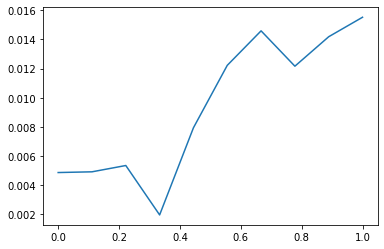

In [216]:
tree_model = lightgbm.LGBMRegressor(learning_rate=0.04)
eval_func = partial(evaluate_panel, metrics_func=corr_func, asset_labels=[1])
corrs = {}

for end_weight in np.linspace(0, 1, 10):
    weighting = linear_weighting(base_train, end_weight)
    corr = fit_model(tree_model, base_train, base_test, train_1, eval_func, sample_weight=weighting)[1][1]
    corrs[end_weight] = corr
pd.Series(corrs).plot()

## Panel Models
Let's run the same process, but for a panel model on the cluster 1, 6, 9.

We do slightly worse (1.1% correlation), but since the construction is different from the above we might still expect some value in an ensemble.

In [111]:
train_169 = train.loc[:, (slice(None), [1, 6, 9])].iloc[300:].fillna(0)

cluster_169 = [1, 6, 9]
tree_model = lightgbm.LGBMRegressor(learning_rate=0.04)
panel_model = MultiOutputRegressor(tree_model, n_jobs=1)
eval_func = partial(evaluate_panel, metrics_func=corr_func, asset_labels=cluster_169)

panel_model, corrs = fit_model(panel_model, base_train, base_test, train_169, eval_func)
print(corrs)

{1: 0.011146811384561705, 6: 0.08807703583664798, 9: 0.0822467941222047}


### Panel Feature Importances
Let's check if this construction makes sense: the idea is that information about other assets is useful for asset 1. We can see this from the feature importances, eg `price_mom_80` for all assets are the highest ranked features for predicting asset 1 returns.

We check this isn't trivially due to substitution effects since these features aren't highly correlated.

In [89]:
fi = panel_model.estimators_[0].feature_importances_
fi = fi / fi.sum()
pd.Series(dict(zip(train_169, fi))).sort_values(ascending=False).head(10)

price_mom_80     1    0.097667
                 6    0.089333
                 9    0.076333
obs_vol_roll_15  1    0.075000
price_mom_15     1    0.054000
                 9    0.052000
                 6    0.048000
obs_vol_roll_15  9    0.047000
price_mom_5      1    0.045000
obs_vol_roll_15  6    0.037333
dtype: float64

In [75]:
train_169.price_mom_80.corr() # low pairwise correlations

Asset_ID,1,6,9
Asset_ID,,,
1,1.000000,-0.029013,-0.017179
6,-0.029013,1.000000,0.033436
9,-0.017179,0.033436,1.000000


## Pool Models

### Single Cluster Pool

Finally, let's rerun for the pooling setup.

This gives the best result - 5.2% correlation out of sample.

In [6]:
train_stacked_169 = train_stacked.loc[(slice(None), [1, 6, 9]), :].dropna()

In [151]:
tree_model = lightgbm.LGBMRegressor(learning_rate=0.04)
eval_func = partial(evaluate_pool, metrics_func=corr_func, asset_labels=cluster_169)

pool_model, corrs = fit_model(tree_model, base_train, base_test, train_stacked_169, eval_func)
print(corrs)

{1: 0.052941912578945836, 6: 0.0875750282120129, 9: 0.09565403822718907}


### All Assets Pool

... let's see the results if fitting on all assets: there is a further improvement. This is consistent with the hypothesis that we do better with more data.

In [124]:
train_stacked_ = train_stacked.dropna()
all_assetsids = np.sort(ad.index.values)
tree_model = lightgbm.LGBMRegressor(learning_rate=0.04)
eval_func = partial(evaluate_pool, metrics_func=corr_func, asset_labels=all_assetsids)

pool_model, corrs = fit_model(tree_model, base_train, base_test, train_stacked_, eval_func)
print(corrs)

{0: 0.06323605623718401, 1: 0.06411559142909154, 2: 0.0385115163741001, 3: 0.06140599837031627, 4: 0.07589535023090965, 5: 0.10505801557330886, 6: 0.09068664881123362, 7: 0.03243507655574745, 8: 0.05236936638345779, 9: 0.11049336463456941, 10: -0.04691362246395552, 11: 0.014789574642226109, 12: 0.0610717908441916, 13: 0.08328190165377237}


Let's check whether this can be improved further by weighting the observations (high volume asset observations should be more highly weighted).

There is surprisingly little difference to the results (this could just be because we have more data for the highly weighted coins so the explicit weighting has little effect).

In [153]:
tree_model = lightgbm.LGBMRegressor(learning_rate=0.04)
eval_func = partial(evaluate_pool, metrics_func=corr_func, asset_labels=all_assetsids)

panel_model, corrs = fit_model(
    tree_model, base_train, base_test, train_stacked_, eval_func, sample_weight=train_stacked_.loc[base_train].target_weight
    )
print(corrs)

{0: 0.06425686729545158, 1: 0.06074381736768591, 2: 0.036233133302478196, 3: 0.05850627375916052, 4: 0.07321166996649121, 5: 0.1024561072527459, 6: 0.08964857859382389, 7: 0.03368548726976016, 8: 0.043520049009335794, 9: 0.1106910564745762, 10: -0.03856261815716083, 11: 0.01104248732595526, 12: 0.05556102936455344, 13: 0.08117724257111841}


## Ensemble Models
All above approaches (single asset, panel, pool) are different, so we might expect averaging to give better results than individual predictions. Let's check this:

All predictions are somewhat correlated, but the panel model is highly correlated with the single asset model. Since it doesn't add much diversification for more complexity drop the panel model and focus on combining pool + single asset models.

FIXME: this is a bit messy - let's make this cleaner for the final solution.

In [246]:
### pool
preds_func = lambda yt, yp: {"true": yt, "pred": yp}

tree_model = lightgbm.LGBMRegressor(learning_rate=0.04)
eval_func = partial(evaluate_pool, metrics_func=preds_func, asset_labels=all_assetsids)

_, pool_preds = fit_model(tree_model, base_train, base_test, train_stacked_, eval_func)

### panel
panel_model = MultiOutputRegressor(tree_model, n_jobs=1)
eval_func = partial(evaluate_panel, metrics_func=preds_func, asset_labels=cluster_169)

_, panel_preds = fit_model(panel_model, base_train, base_test, train_169, eval_func)

### single
eval_func = partial(evaluate_panel, metrics_func=preds_func, asset_labels=[1])

_, single_preds = fit_model(tree_model, base_train, base_test, train_1, eval_func)

all_preds = {
    "single": single_preds[1]["pred"],
    "pool": pool_preds[1]["pred"],
    "panel": panel_preds[1]["pred"],
    "true": single_preds[1]['true'],
    }
all_preds = pd.DataFrame(all_preds)
print(all_preds.corr())

          single      pool     panel      true
single  1.000000  0.188878  0.508199  0.015526
pool    0.188878  1.000000  0.139867  0.064116
panel   0.508199  0.139867  1.000000  0.011147
true    0.015526  0.064116  0.011147  1.000000


We have an optimum when combining pool + single predictions in a 95:5 ratio - since the pool model does much better than the single asset model we expected the pool model to have a higher weight.

<AxesSubplot:>

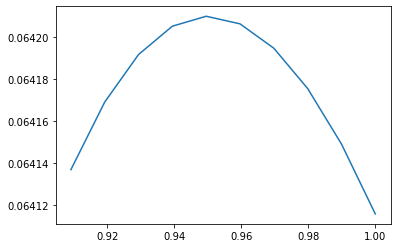

In [268]:
combined_preds = lambda t: all_preds["pool"] * t + all_preds["single"] * (1-t)
combined_corr = lambda t: combined_preds(t).corr(all_preds["true"])
combined_corrs = {t: combined_corr(t) for t in np.linspace(0, 1, 100)}

pd.Series(combined_corrs).loc[0.9:].plot() # plot a subset to show the optimum

## Final Models

### Panel and Single Asset Models
From the above results, we focus on combining panel + pool models. We write an class `PoolRegressor` to make it easier to work with pooled + single asset models.

### Configuration
The setup for these models will be:
- Fit pool models on each cluster and for all assets
- Average over `Lasso` + `LGBM` models
- Average over single asset and pool models

### Hyperparameter Tuning
Let's find an optimal set of hyperparameters from cross validation:
- Regularisation for `Lasso`
- Configuration of the `NN` model (# of layers, regularisation, ...)
- Parameters for the `LGBM` tree model
- Relative weighting of each model

The procedure will be:
- Consider one cluster (1, 6, 9) for simplicity (assume similar optimal hyperparameters for other clusters)
- Optimise parameters for each model separately
- Next, decide an optimal allocation to each model

The specific CV setup:
- Use an expanding window for CV with 5 folds
  - Can use more folds for better results, but stick with 5 for simplicity
- Select the model with the best average CV score. Some anticipated issues:
  - Models generally do better with more data, so can make the optimisation more difficult
    - Can fix by doing k-fold CV as in de Prado's `Advances in Financial Machine Learning`


Update:
Some problems encountered:

- Sometimes the optimal model found is at the edge of the parameters searched
  - The optimal parameters are likely beyond the parameters searched
  - To save time ignore this, but it should be fixed by extending the parameters searched

In [11]:
from sklearn.model_selection import GridSearchCV

cv_timestamps = train_stacked_169.index.get_level_values(0).unique()
# cv_splits = cv_split(cv_timestamps, n_splits=5, overlap=16, embargo=7*24*60) # 7 days embargo
cv_splits = ts_split(cv_timestamps, n_splits=5, split_ratio=0, overlap=16) # expanding window
cv_indices = timestamp_folds_to_indices(cv_splits, train_stacked_169.index.get_level_values(0))

def run_cv(base_model, grid, pool=True, cv_inds=cv_indices, cluster=(1, 6, 9), stacked_data_=train_stacked_169, **fit_kwargs):
    """Run GridSearchCV on the (1, 6, 9) cluster for pool models, otherwise
    run for single asset models.
    """
    if pool:
        model = PoolRegressor(base_model, clusters={0: cluster})
    else:
        model = single_asset_regressor(base_model, cluster)
    rcv = GridSearchCV(model, param_grid=grid, cv=cv_inds, n_jobs=1).fit(stacked_data_, **fit_kwargs)
    return grid_res_to_df(rcv)

### Lasso Model

#### Pool

- There is relatively little impact from changing the regularisation.
- This could be an issue with the CV setup, eg:
  - The score is generally increasing since we give the training window is expanding
  - Non-stationarity: We might expect the score to be more consistent across folds

(0.0022222223000000004, False)

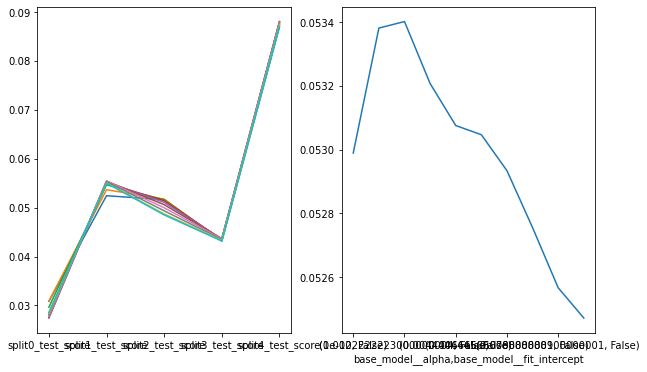

In [23]:
grid = {"base_model__alpha": np.linspace(1e-10, 1e-2, 10), "base_model__fit_intercept": [False,]}
df_lasso_pool = run_cv(Lasso(), grid, True)
scores = plot_cv_scores(df_lasso_pool)
scores.mean().idxmax() # prado

#### Single Asset

(0.011111111188888889, False)

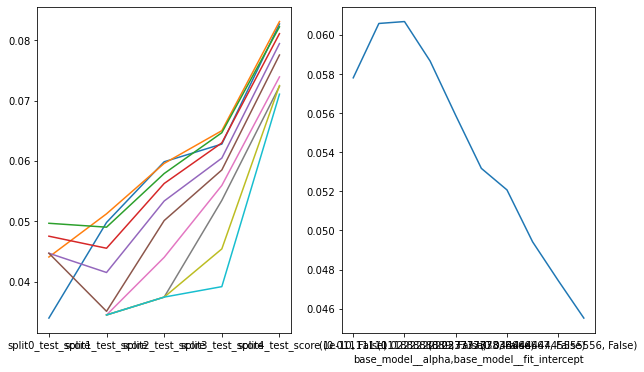

In [22]:
grid = {"base_model__alpha": np.linspace(1e-10, 0.05, 10), "base_model__fit_intercept": [False,]}
df_lasso_single = run_cv(Lasso(), grid, False)
scores = plot_cv_scores(df_lasso_single)
scores.mean().idxmax() # prado

### LGBM Model

#### Pool
- The scores look *very* similar to the lasso model
  - They are slightly better, but the general shape is the same
  - Possibly expected from the 'No Free Lunch' theorem
    - (on average all models perform the same)

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM]

(0.0, 0.01, 400)

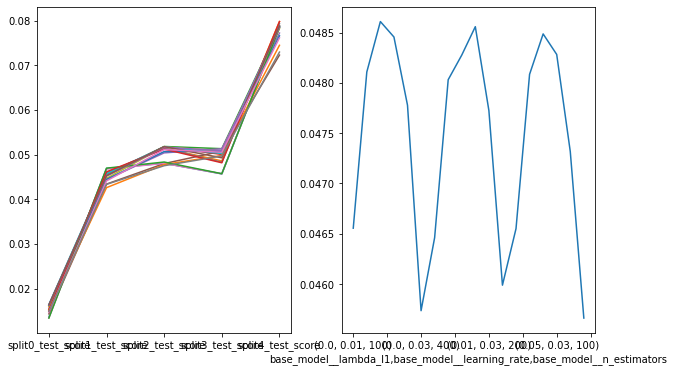

In [31]:
grid = {
    "base_model__learning_rate": np.arange(1, 5, 2)/100,
    "base_model__n_estimators": [100, 200, 400],
    "base_model__lambda_l1": [0, 0.01, 0.05],
    }
df_lgbm_pool = run_cv(lightgbm.LGBMRegressor(), grid, True)
scores = plot_cv_scores(df_lgbm_pool)
scores.mean().idxmax()

#### Single Asset

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM]

(0.01, 0.03, 100)

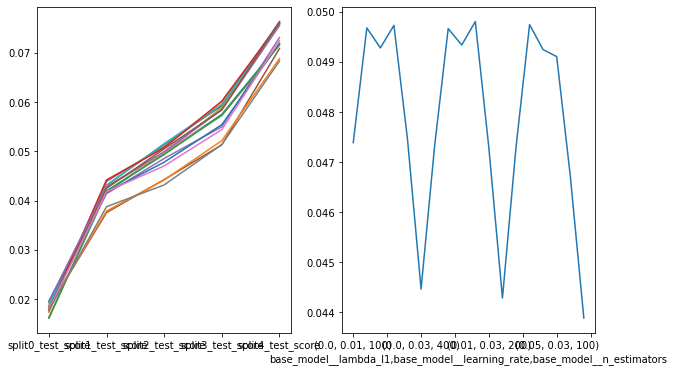

In [30]:
grid = {
    "base_model__learning_rate": np.arange(1, 5, 2)/100,
    "base_model__n_estimators": [100, 200, 400],
    "base_model__lambda_l1": [0, 0.01, 0.05],
    }
df_lgbm_single = run_cv(lightgbm.LGBMRegressor(), grid, False)
scores = plot_cv_scores(df_lgbm_single)
scores.mean().idxmax() # prado

### Neural Net Model
I had issues training these models - to save time we drop these.

#### Pool
Pick (1000, ((dense, 8), (dense, 4), (dense, 4)), 5)

In [1]:
from lib.models import create_nn_model
nn_model = KerasRegressor(build_fn=create_nn_model)

grid = {
    "base_model__model_layers": [
        (("dense", 4),),
        (("dense", 4), ("dropout", 0.005)),
        (("dense", 8), ("dense", 4)),
        (("dense", 8), ("dropout", 0.005), ("dense", 4)),
    ],
    "base_model__batch_size": [1000,],
    "base_model__epochs": [1, 5, 10],
    }

df_nn_pool = run_cv(nn_model, grid, True)
scores = plot_cv_scores(df_nn_pool)
scores.mean().idxmax()

NameError: name 'KerasRegressor' is not defined

#### Single

In [7]:
# nn_model = KerasRegressor(build_fn=create_nn_model)

# grid = {
#     "base_model__model_layers": [
#         (("dense", 4),),
#         (("dense", 4), ("dropout", 0.001)),
#         (("dense", 8), ("dense", 4)),
#         (("dense", 8), ("dropout", 0.001), ("dense", 4)),
#     ],
#     "base_model__batch_size": [1000, 5000],
#     "base_model__epochs": [1, 5, 10],
#     }

# df_nn_single = run_cv(nn_model, grid, False)
# scores = plot_cv_scores(df_nn_single)
# scores.mean().idxmax()

## Pool All Assets
Earlier we also considered a pooled model across all assets. Let's tune Lasso + LGBM + NN models for these too.

(For simplicity, search a reduced set of parameters for these.)

In [9]:
all_assetids = ad.index.values
train_stacked_ = train_stacked.dropna()

cv_timestamps_all = train_stacked_.index.get_level_values(0).unique()
# cv_splits_all = cv_split(cv_timestamps_all, n_splits=5, overlap=16, embargo=7*24*60) # 7 days embargo
cv_splits_all = ts_split(cv_timestamps_all, n_splits=5, split_ratio=0, overlap=16) # expanding window
cv_indices_all = timestamp_folds_to_indices(cv_splits_all, train_stacked_.index.get_level_values(0))

### Lasso

/home/lib/lib/metrics.py:25: RuntimeWarning: invalid value encountered in double_scalars
  corr = cov / np.sqrt(var_a * var_b)
/home/lib/lib/metrics.py:25: RuntimeWarning: invalid value encountered in double_scalars
  corr = cov / np.sqrt(var_a * var_b)
/home/lib/lib/metrics.py:25: RuntimeWarning: invalid value encountered in double_scalars
  corr = cov / np.sqrt(var_a * var_b)
/home/lib/lib/metrics.py:25: RuntimeWarning: invalid value encountered in double_scalars
  corr = cov / np.sqrt(var_a * var_b)
/home/lib/lib/metrics.py:25: RuntimeWarning: invalid value encountered in double_scalars
  corr = cov / np.sqrt(var_a * var_b)
/home/lib/lib/metrics.py:25: RuntimeWarning: invalid value encountered in double_scalars
  corr = cov / np.sqrt(var_a * var_b)
/home/lib/lib/metrics.py:25: RuntimeWarning: invalid value encountered in double_scalars
  corr = cov / np.sqrt(var_a * var_b)
/home/lib/lib/metrics.py:25: RuntimeWarning: invalid value encountered in double_scalars
  corr = cov / np.sqrt

(0.016733333333333333, False)

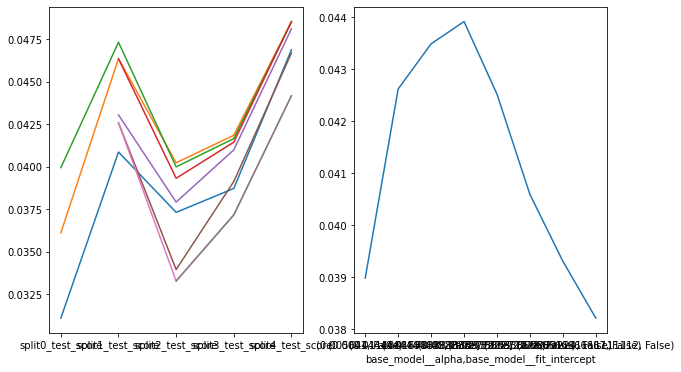

In [12]:
grid = {"base_model__alpha": np.linspace(1e-4, 5e-2, 10), "base_model__fit_intercept": [False,]}
pool_all_lasso = run_cv(Lasso(), grid, pool=True, cv_inds=cv_indices_all, cluster=all_assetids, stacked_data_=train_stacked_)
scores = plot_cv_scores(pool_all_lasso)
scores.mean().idxmax()

### LGBM

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0

(0.01, 0.03, 200)

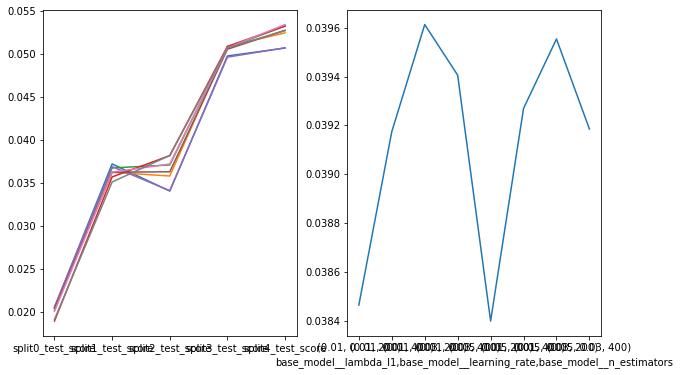

In [15]:
grid = { 
    "base_model__learning_rate": [0.01, 0.03],
    "base_model__n_estimators": [200, 400],
    "base_model__lambda_l1": [0.01, 0.05],
    } # smaller set of params explored for faster results
pool_all_lgbm = run_cv(lightgbm.LGBMRegressor(), grid, pool=True, cv_inds=cv_indices_all, cluster=all_assetids, stacked_data_=train_stacked_)
scores = plot_cv_scores(pool_all_lgbm)
scores.mean().idxmax() # prado

### NN
... as before had problems fitting so drop

In [16]:
from lib.models import create_nn_model
nn_model = create_nn_model

grid = {
    "base_model__model_layers": [
        (("dense", 4),),
        (("dense", 4), ("dropout", 0.005)),
        (("dense", 8), ("dense", 4)),
        (("dense", 8), ("dropout", 0.005), ("dense", 4)),
    ],
    "base_model__batch_size": [1000, 5000],
    "base_model__epochs": [1, 5, 10, 20],
    }

pool_all_nn = run_cv(nn_model, grid, pool=True, cv_inds=cv_indices_all, cluster=all_assetids, stacked_data_=train_stacked_)
scores = plot_cv_scores(pool_all_nn)
scores.mean().idxmax() # prado

AttributeError: 'function' object has no attribute 'set_params'

## Model Allocations

Using the hyperparameters we've found, we now decide:
- How much weight to assign to the Lasso/LGBM models
- How much weight to assign to the pool/pool_all/single models

The procedure:
- Use the same CV setup as before (expanding window)
  - Note: these test sets are contaminated since they've been used for hyperparameter optimisation
    - We're optimising a different objective however so I don't expect too much overfitting
    - (Especially since we're doing CV - can mitigate overfitting issues by using more folds)
- Train all models on + compute out of sample predictions
- Compute the post-hoc ideal allocations to each model
- Average these allocations across folds to compute the final allocations

In [20]:
from keras.wrappers.scikit_learn import KerasRegressor
nn_model = KerasRegressor(build_fn=create_nn_model)

all_assetids = list(range(14))

pool_params = {
    "lasso": {
        "model": Lasso(),
        "params": {"alpha": 0.0022222223000000004, "fit_intercept": False},
    },
    "LGBM": {
        "model": lightgbm.LGBMRegressor(),
        "params": {"learning_rate": 0.01, "lambda_l1": 0.0, "n_estimators": 400, "alpha": 3}
    },
    # "NN": {
    #     "model": KerasRegressor(create_nn_model),
    #     "params": {"epochs": 5, "batch_size": 1000, "model_layers": (("dense", 8), ("dense", 4), ("dense", 4))},
    # },
}

single_params = {
    "lasso": {
        "model": Lasso(),
        "params": {"alpha": 0.011111111188888889, "fit_intercept": False},
    },
    "LGBM": {
        "model": lightgbm.LGBMRegressor(),
        "params": {"learning_rate": 0.01, "lambda_l1": 0.03, "n_estimators": 100, "alpha": 3}
    },
    # "NN": {
    #     "model": KerasRegressor(create_nn_model),
    #     "params": {"epochs": 5, "batch_size": 1000, "model_layers": (("dense", 8), ("dense", 4), ("dense", 4))},
    # },
}

all_params = {
    "lasso": {
        "model": Lasso(),
        "params": {"alpha": 0.016733333333333333, "fit_intercept": False},
    },
    "LGBM": {
        "model": lightgbm.LGBMRegressor(),
        "params": {"learning_rate": 0.02, "lambda_l1": 0.01, "n_estimators": 200}
    },
    # "NN": {
    #     "model": KerasRegressor(create_nn_model),
    #     "params": {"epochs": 10, "batch_size": 1000, "model_layers": (("dense", 8), ("dense", 4))},
    # },
}

param_dict = {
    "pool": {
        "params": pool_params,
        "clusters": clusters,
    },
    "single": {
        "params": single_params,
        "clusters": {k: [k] for k in all_assetids}, # FIXME: should use `single_asset_regressor`
    },
    "pool_all": {
        "params": all_params,
        "clusters": {-1: all_assetids},
    },
}

In [12]:
# train_stacked_ = train_stacked.dropna()
# (train_2, test_2), = ts_split(train_ind, 5, 0.2)

# train_2_stacked = train_stacked_.loc[train_2]
# test_2_stacked = train_stacked_.loc[test_2]


# all_assetids = ad.index.values
# train_stacked_ = train_stacked.dropna()

# cv_timestamps_all = train_stacked_.index.get_level_values(0).unique()
# # cv_splits_all = cv_split(cv_timestamps_all, n_splits=5, overlap=16, embargo=7*24*60) # 7 days embargo
# cv_splits_all = ts_split(cv_timestamps_all, n_splits=5, split_ratio=0, overlap=16) # expanding window
# cv_indices_all = timestamp_folds_to_indices(cv_splits_all, train_stacked_.index.get_level_values(0))

### Baseline on averaging Pool models
Let's do a simple allocation to see if our approach will work.

We do a `1/N` (equal weighted mean) allocation to lasso + LGBM pool models. We already see a benefit to model averaging.

In [36]:
(train_2, test_2), = ts_split(train_ind, 1, 0.2)
test_2_stacked = train_stacked_.loc[test_2]

paramed_pool = fit_on_params(param_dict["pool"]["params"], param_dict["pool"]["clusters"], train_stacked_.loc[train_2]) # fit pool models
paramed_pool_preds = {k: m.predict(test_2_stacked) for k, m in paramed_pool.items()} # get predictions

avg_preds = sum(paramed_pool_preds.values()) / len(paramed_pool_preds) # equal weighted predictions across lasso + LGBM + NN
corrs__ = pd.Series({k: weighted_correlation(v, test_2_stacked.target, test_2_stacked.target_weight) for k, v in {**paramed_pool_preds, "avg": avg_preds}.items()})
corrs__

lasso    0.048565
LGBM     0.046339
avg      0.051327
dtype: float64

Let's optimise this allocation for all models. We don't want the allocation to be impacted by models performing badly due to lack of data (expect simpler models to be better on earlier folds), so split into 10 expanding windows and take predictions only in the last 5 of these.

In [51]:
alloc_folds = ts_split(train_ind, 10, 0)[5:]

all_X = [train_stacked_.loc[test_dt] for _, test_dt in alloc_folds]
all_preds = []

for train_dt, test_dt in alloc_folds:
    fold_preds = params_to_preds(param_dict, train_stacked_.loc[train_dt], train_stacked_.loc[test_dt])
    all_preds.append(pd.DataFrame(fold_preds))

[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0


In [151]:
from lib.models import score_from_df
from scipy.optimize import minimize, LinearConstraint

def avg_preds(preds_df, model_weights):
    """Calculate a weighted average of a list of predictions using the given model weights"""
    assert preds_df.shape[1] == len(model_weights)
    return (preds_df @ model_weights) / sum(model_weights)

def neg_wt_corr(model_weights, preds_df, X):
    """Calculate the weighted average prediction across models and then the weighted correlation"""
    return -score_from_df(avg_preds(preds_df, model_weights), X)
    

def find_optim_allocation(preds_df, X):
    """Take a dictionary of model predictions and returns a dictionary of allocations
    optimising the weighted prediction correlation
    """
    n_models = preds_df.shape[1]
    init_guess = np.ones(n_models)/n_models
    neg_wt_corr_ = lambda w: neg_wt_corr(w, preds_df, X)
    
    bounds = [(0, 1) for _ in range(n_models)]
    sum_constraint = LinearConstraint(np.ones(n_models), 1, 1) # sum of weights = 1
    
    optim_model_wts = minimize(neg_wt_corr_, init_guess, bounds=bounds, constraints=sum_constraint)
    return dict(zip(preds_df.columns, optim_model_wts.x))

<AxesSubplot:>

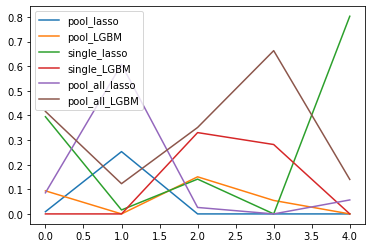

In [152]:
optim_allocs_init = [find_optim_allocation(*a) for a in zip(all_preds, all_X)]
optim_allocs_df_init = pd.DataFrame(optim_allocs)
optim_allocs_df_init.plot()

... the allocations look noisy but stable. Let's concatenate the predictions and split into more folds and for a more detailed picture.

Split into 200 disjoint sets and compute the best allocation on each one. Since these sets are small, expect the result to be noisy.

In [99]:
concat_X = pd.concat(all_X)
concat_preds = pd.concat(all_preds).reindex(concat_X.index) # in case indexes don't match
concat_timestamps = concat_preds.index.get_level_values(0).unique()

In [167]:
from sklearn.model_selection import KFold
from lib.cross_validation import _index_timestamps

n_splits = 200

# don't worry about information leakage for simplicity. Any bias applies to all folds so has no effect on results.
kf = KFold(n_splits=n_splits).split(concat_timestamps) # 
kf_timestamps = [x[1] for x in _index_timestamps(kf, concat_timestamps)]
len(kf_timestamps[0])

2845

In [168]:
opt_allocs = []

for fold in kf_timestamps:
    opt_allocs.append(find_optim_allocation(concat_preds.loc[fold], concat_X.loc[fold]))
    
opt_allocs_df = pd.DataFrame(opt_allocs)

In [173]:
opt_allocs_df.mean()

pool_lasso        0.138034
pool_LGBM         0.106735
single_lasso      0.165630
single_LGBM       0.147210
pool_all_lasso    0.211474
pool_all_LGBM     0.230917
dtype: float64

<AxesSubplot:>

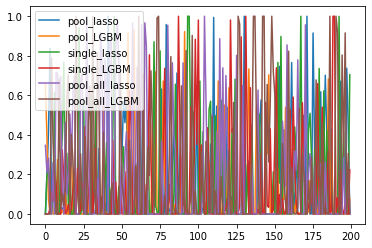

In [171]:
opt_allocs_df.plot() # unstable

In [187]:
opt_allocs_df.describe().loc[["mean", "50%"]].round(4)

,pool_lasso,pool_LGBM,single_lasso,single_LGBM,pool_all_lasso,pool_all_LGBM
mean,0.138,0.1067,0.1656,0.1472,0.2115,0.2309
50%,0.000,0.0000,0.0000,0.0180,0.0000,0.0342


Observations:
- Most of the time most models are not selected
  - Possibly expected since the optimisation could just pick the single best model
- Models do have non-zero mean weights -> Select these for the final allocations
- There is a preference for the pool_all models
  - Could be explained since they use the most amount of data for fitting
- Lasso and tree models have equal weights
  - This suggests either:
    - The tree models are overfitting and averaging with a simpler model helps this
    - Both do equally as well since the patterns to learn are well-captured by a simple lasso model
      - I find this more plausible since the feature set isn't large

Possible improvements:
- Improve the optimisation, eg impose a weight limit.

Let's check what the `1/N` vs (in sample) optimal allocation weighted correlation to see what improvement we have.

There is a 1% improvement - this is a small marginal improvement (and in-sample) so could be explained by the models themselves producing highly correlated predictions (they should be since the targets are the same). 

In [191]:
opt_alloc_mean = opt_allocs_df.mean().values
alloc_dict = dict(zip(concat_preds.columns, opt_alloc_mean))
print(alloc_dict)

equal_corr = -neg_wt_corr([1 for _ in range(6)], concat_preds, concat_X)
optim_corr = -neg_wt_corr(opt_alloc_mean, concat_preds, concat_X)
print(equal_corr, optim_corr, optim_corr / equal_corr)

{'pool_lasso': 0.13803354577335214, 'pool_LGBM': 0.10673472669853526, 'single_lasso': 0.16562975805884267, 'single_LGBM': 0.14721038027645952, 'pool_all_lasso': 0.21147431517754645, 'pool_all_LGBM': 0.23091727401526385}
0.05709456610644105 0.0576982191633032 1.0105728635495148


#### Final Allocations
Let's (finally!) train on all training data and test on the validation set to check whether our expectations hold on unseen data.

In [204]:
from sklearn.ensemble import VotingRegressor
from lib.models import PoolVotingRegressor

final_allocations = {
    'pool_lasso': 0.13803354577335214,
    'pool_LGBM': 0.10673472669853526,
    'single_lasso': 0.16562975805884267,
    'single_LGBM': 0.14721038027645952,
    'pool_all_lasso': 0.21147431517754645,
    'pool_all_LGBM': 0.23091727401526385,
}

all_assetids = list(range(14))

pool_params = {
    "lasso": {
        "model": Lasso(),
        "params": {"alpha": 0.0022222223000000004, "fit_intercept": False},
    },
    "LGBM": {
        "model": lightgbm.LGBMRegressor(),
        "params": {"learning_rate": 0.01, "lambda_l1": 0.0, "n_estimators": 400, "alpha": 3}
    },
}

single_params = {
    "lasso": {
        "model": Lasso(),
        "params": {"alpha": 0.011111111188888889, "fit_intercept": False},
    },
    "LGBM": {
        "model": lightgbm.LGBMRegressor(),
        "params": {"learning_rate": 0.01, "lambda_l1": 0.03, "n_estimators": 100, "alpha": 3}
    },
}

all_params = {
    "lasso": {
        "model": Lasso(),
        "params": {"alpha": 0.016733333333333333, "fit_intercept": False},
    },
    "LGBM": {
        "model": lightgbm.LGBMRegressor(),
        "params": {"learning_rate": 0.02, "lambda_l1": 0.01, "n_estimators": 200}
    },
}

param_dict = {
    "pool": {
        "params": pool_params,
        "clusters": clusters,
    },
    "single": {
        "params": single_params,
        "clusters": {k: [k] for k in all_assetids},
    },
    "pool_all": {
        "params": all_params,
        "clusters": {-1: all_assetids},
    },
}

all_models = {
    f"{setup}_{model_type}": PoolRegressor(model["model"].set_params(**model["params"]), clusters=model_dict["clusters"])
    for setup, model_dict in param_dict.items()
    for model_type, model in model_dict["params"].items()
}
models_list = [(k, model) for k, model in all_models.items()]
model_weight_list = [final_allocations[k] for k in all_models] # ensure in same order

voting_model = PoolVotingRegressor(estimators=models_list, weights=model_weight_list)

In [205]:
train_stacked_ = train_stacked.dropna()

voting_model.fit(train_stacked_)

[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0


In [209]:
valid_stacked = data.loc[validation_ind].stack().join(target_weights, on="Asset_ID").dropna() # FIXME: this should be done in the library
voting_model.score(valid_stacked) # weighted correlation

0.051358259279686215

... slightly less than the 0.0576... score we had previously, but not out of line with expectations (especially since we burned a lot of the data for hyperparameter + allocation tuning).


Let's check the scores from the individual models. We see that all models performed well, and that there is a benefit from model diversification (the final 5.1% score is greater than all individual scores).

In [210]:
def pool_voting_reg_to_ind_corrs(voting_reg, test):
    """Returns a dict of individual weighted correlation scores of PoolRegressors in a PoolVotingRegressor"""
    individual_corrs = [estim.score(test) for estim in voting_reg.voting_regressor_.estimators_]
    individual_corrs = dict(zip([x[0] for x in voting_reg.voting_regressor_.estimators], individual_corrs))
    return individual_corrs
    
pool_voting_reg_to_ind_corrs(voting_model, valid_stacked)

{'pool_lasso': 0.047406212497645935,
 'pool_LGBM': 0.042392462718265876,
 'single_lasso': 0.0484193879332021,
 'single_LGBM': 0.04505776155336297,
 'pool_all_lasso': 0.04673696977343687,
 'pool_all_LGBM': 0.04817929503869379}

### Next Steps
At this point I would iterate on my results to fix some of the issues I've seen, especially for the hyperparameter tuning (use more folds).

Note: we still haven't seen the test set so we can iterate and testing on the validation set and only look at the test set after we've tested everything we want to test. To save time however, I will not iterate further.

Let's repeat the above but retrain on train + validation and test on the unseen test set:

In [217]:
test_stacked = data.loc[test_ind].stack().join(target_weights, on="Asset_ID").dropna() # FIXME: this should be done in the library

In [222]:
train_stacked.loc["target"].std()

0.0019376773818993698

In [223]:
test_stacked.loc[(slice(None), 1), "target"].std()

0.0025139233771823226

In [211]:
full_train_stacked_ = pd.concat([train_stacked_, valid_stacked])

In [212]:
voting_model_ = PoolVotingRegressor(estimators=models_list, weights=model_weight_list).fit(full_train_stacked_)

[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0


In [213]:
voting_model_.score(test_stacked)

0.03608683500634101

... even less than the roughly 5% correlations we seen previously. What happened?

Looking at the individual model breakdowns we still see the pool_all models doing better than the other model setups, however the LGBM models are now outperforming the lasso models - I suspect this could be a data normalisation issue since the tree models are robust to outliers and invariant under (monotonic) feature transformations.

We noted in the data exploration notebook that the last 20% of all data is during volatile market conditions and that this could make our models perform worse since the data the models have seen are from 'normal' market conditions (whatever this means for crypto assets...). To test whether this is true, the models could be trained and tested on the data from volatile periods and performance compared (or weight the volatile observations more). To save time however I'll skip this for now.

In [214]:
pool_voting_reg_to_ind_corrs(voting_model_, test_stacked)

{'pool_lasso': 0.02921951444659187,
 'pool_LGBM': 0.03313675849277464,
 'single_lasso': 0.025480751642864948,
 'single_LGBM': 0.01677176626351677,
 'pool_all_lasso': 0.025293642305934526,
 'pool_all_LGBM': 0.03867315251363824}

## Conclusion
The results seem promising since the out of sample scores are in line with our expectations.

Since the models will be tested on volatile conditions and from interpreting the results on the test set it seems sensible to adjust our allocations more in favour of the LGBM models since these generalise better than the lasso models (at least on the test set).

For faster research + due to anticipated computational (RAM) difficulties the feature set is small. Since the ratio of data points to features is large, I anticipate adding features will only improve results - especially lagged features since this is a sequence modelling problem and because we're using static models (above we saw the price momentum features being highly ranked for example). Ideally this should have been tested to find the relevant features to lag, but to save time I'll add lagged features with shifts I think would be useful (and that fit in memory).